In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from numpy import asarray
from numpy import sqrt

from pandas import concat
from pandas import DataFrame


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM

In [2]:
#import raw dataset

file = "Volve production data.xlsx"
#file = "https://docs.google.com/spreadsheets/d/1wEus6YNRmfPdbMk0hAiMgnq7DRLboM5j/edit?usp=sharing&ouid=103845268356617498520&rtpof=true&sd=true"
sheet = "Daily Production Data"

df = pd.read_excel(file, sheet)

In [60]:
#define columns to drop
drop_cols = ["WELL_BORE_CODE", 'NPD_FIELD_CODE', 'NPD_FIELD_NAME', "NPD_WELL_BORE_NAME", 'NPD_FACILITY_CODE',
             "BORE_WI_VOL", "FLOW_KIND", "WELL_TYPE", 'NPD_FACILITY_NAME', 'AVG_CHOKE_UOM']

#drop columns and assign new dataframe
df_new = df.drop(columns = drop_cols)

#set index
df_new = df_new.set_index('DATEPRD')
date_time = pd.to_datetime(df_new.index, format='%d.%m.%Y %H:%M:%S')

#drop injection wells data
df_new = df_new[ (df_new['NPD_WELL_BORE_CODE'] != 5693) & (df_new['NPD_WELL_BORE_CODE'] != 5769) ]

#Data is highly skewed, hence pad the missing values
for col in df_new.columns:
    df_new[col] = df_new[col].fillna(method='pad')
    
#convert the production rates to per day
prod_cols = ["BORE_OIL_VOL", "BORE_GAS_VOL", "BORE_WAT_VOL"]
for col in prod_cols:
    df_new[col] = df_new[col]/df_new["ON_STREAM_HRS"]*24
    df_new[col] = df_new[col].fillna(0)
    
#pd.plotting.scatter_matrix(df_new, alpha=0.2, figsize=(25, 25), diagonal="hist")
#plt.show()

#create dataframe dictionary where each key corresponds to each well
df_dict = {well_code:df_new[df_new.NPD_WELL_BORE_CODE == well_code]
           for well_code in df_new['NPD_WELL_BORE_CODE'].unique()}

#drop well codes inplace and set index
for well_code in df_dict:
    df_dict[well_code] = df_dict[well_code].drop(columns = ["NPD_WELL_BORE_CODE", "ON_STREAM_HRS"])

    
print(df_dict.keys())
df_dict[7405]

dict_keys([7405, 7078, 5599, 5351, 7289])


,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL
DATEPRD,,,,,,,,,,,
2014-04-07,0.00000,0.00000,0.00000,0.0,0.000000,0.00000,0.00000,0.00000,0.0,0.0,0.0
2014-04-08,0.00000,0.00000,0.00000,0.0,1.003059,0.00000,0.00000,0.00000,0.0,0.0,0.0
2014-04-09,0.00000,0.00000,0.00000,0.0,0.979008,0.00000,0.00000,0.00000,0.0,0.0,0.0
2014-04-10,0.00000,0.00000,0.00000,0.0,0.545759,0.00000,0.00000,0.00000,0.0,0.0,0.0
2014-04-11,310.37614,96.87589,277.27826,0.0,1.215987,33.09788,10.47992,33.07195,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2016-04-17,270.26849,101.19807,263.77035,0.0,0.000000,6.49814,9.80247,2.64528,0.0,0.0,0.0
2016-04-18,276.86895,101.23102,263.15498,0.0,0.000000,13.71397,11.74224,4.12000,0.0,0.0,0.0
2016-04-19,282.10538,101.17754,273.52959,0.0,0.265188,8.57579,10.11906,1.86628,0.0,0.0,0.0


In [33]:
#function to get well data given the well code
def get_df(well_code):
    return df_dict[well_code]

#function to get test & train data given the well code
def get_test_and_train_data(well_code):

    well_df = get_df(well_code)

    X = well_df.drop(columns = ["BORE_OIL_VOL", "BORE_GAS_VOL", "BORE_WAT_VOL"])
    y = well_df[["BORE_OIL_VOL", "BORE_GAS_VOL", "BORE_WAT_VOL"]]
    
    return train_test_split(X, y, test_size = 0.3, random_state=42)

def get_outputs(well_code):
    well_df = get_df(well_code)
    
    return tuple([well_df[col] for col in ["BORE_OIL_VOL", "BORE_GAS_VOL", "BORE_WAT_VOL"]])

#print (get_outputs(7405)[0])


# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    
    for i in range(len(sequence)):
        
        # find the end of this pattern
        end_ix = i + n_steps
        
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
            
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
        
    return asarray(X), asarray(y)

(2139, 8) (917, 8) (2139, 3) (917, 3)


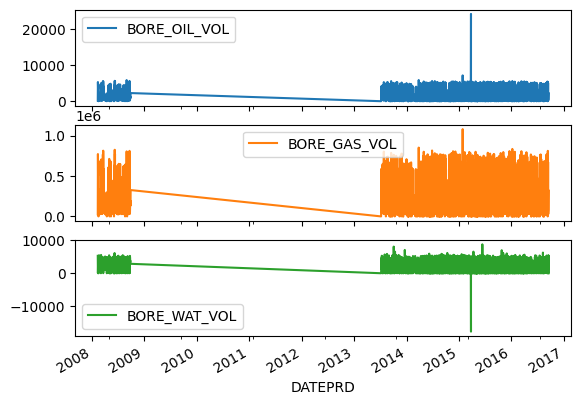

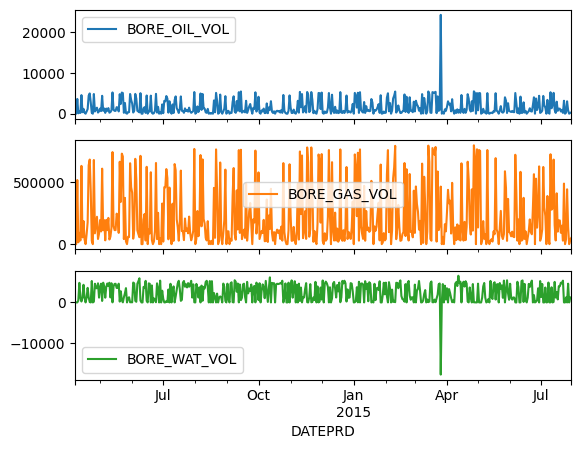

In [41]:
well_code = 5599
well_df = get_df(well_code)
X_train, X_test, y_train, y_test = get_test_and_train_data(well_code)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

plot_cols = ["BORE_OIL_VOL", "BORE_GAS_VOL", "BORE_WAT_VOL"]
plot_features = y_train[plot_cols]
plot_features.index = date_time[:y_train.shape[0]]
_ = plot_features.plot(subplots=True)

plot_features = y_train[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

plt.show()

In [42]:
well_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3056 entries, 2008-02-12 to 2016-09-17
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   AVG_DOWNHOLE_PRESSURE     3056 non-null   float64
 1   AVG_DOWNHOLE_TEMPERATURE  3056 non-null   float64
 2   AVG_DP_TUBING             3056 non-null   float64
 3   AVG_ANNULUS_PRESS         3056 non-null   float64
 4   AVG_CHOKE_SIZE_P          3056 non-null   float64
 5   AVG_WHP_P                 3056 non-null   float64
 6   AVG_WHT_P                 3056 non-null   float64
 7   DP_CHOKE_SIZE             3056 non-null   float64
 8   BORE_OIL_VOL              3056 non-null   float64
 9   BORE_GAS_VOL              3056 non-null   float64
 10  BORE_WAT_VOL              3056 non-null   float64
dtypes: float64(11)
memory usage: 286.5 KB


In [ ]:
pd.plotting.scatter_matrix(X_train, alpha=0.2, figsize=(25, 25), diagonal="hist")

plt.show()

# RNN - lstm

#univariate

In [ ]:
# load the dataset
oil_prod = get_outputs(7405)[0]

# retrieve the values
values = oil_prod.values.astype('float32')

# specify the window size
n_steps = 7

# split into samples
X, y = split_sequence(values, n_steps)

# reshape into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# define model
model = Sequential()

model.add(Input(shape=(X_train.shape[1],)))

In [ ]:
model.add(LSTM(100, activation='relu', kernel_initializer='he_normal'))

In [ ]:
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# fit the model
model.fit(X_train, y_train, epochs=350, batch_size=32, verbose=2, validation_data=(X_test, y_test))

# evaluate the model
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, sqrt(mse), mae))

# make a prediction


In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

#  MLP

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# determine the number of input & output features
features_in = X_train.shape[1]
features_out = y_train.shape[1]

# define model
mlp = Sequential()

mlp.add(Input(shape=(features_in,)))

mlp.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
mlp.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
mlp.add(Dense(features_out))

# compile the model
mlp.compile(optimizer='adam', loss='mse')

# fit the model
mlp.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)

# evaluate the model
error = mlp.evaluate(X_test, y_test, verbose=2)
print('MSE: %.3f, RMSE: %.3f' % (error, sqrt(error)))
